In [1]:
# --- Mount & Setup ---
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS 495 DataScience Capstone Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS 495 DataScience Capstone Project


In [2]:
# --- Imports ---
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [3]:
# --- Load Data ---
test_df = pd.read_csv("prompt_synopsis_test.csv")
selected_rows = [20, 26, 64, 84, 88, 98, 106, 111, 127, 164,
                 190, 199, 225, 231, 242, 244, 259, 298, 10597, 10609]
test_df = test_df.iloc[selected_rows].reset_index(drop=True)
input_prompts = test_df["prompt"]
output_synopsis = test_df["synopsis"]
tags = test_df["tags_combined"]

In [4]:
# --- Hyperparameters ---
vocab_size = 40000
enc_max_len = 64
dec_max_len = 150
max_generated_length = 50
embedding_dim = 128
units = 128

In [5]:
# --- Load Tokenizer & Model ---
with open("tokenizer_LSTM-GRU_40k.pkl", "rb") as f:
    tokenizer = pickle.load(f)
model = load_model("lstm_gru_model_40k.keras")

start_token_id = tokenizer.word_index["<BOS>"]
end_token_id = tokenizer.word_index["<EOS>"]
pad_token_id = tokenizer.word_index["<PAD>"]

In [6]:
# --- Build Inference Encoder ---
encoder_inputs_inf = Input(shape=(enc_max_len,), name="encoder_input")
encoder_emb = model.get_layer("embedding")(encoder_inputs_inf)
encoder_outputs_inf, state_h_inf, state_c_inf = model.get_layer("encoder_lstm")(encoder_emb)
encoder_model = Model(inputs=encoder_inputs_inf, outputs=[state_h_inf, state_c_inf])

# --- Build Inference Decoder ---
decoder_input_token = Input(shape=(1,), name="decoder_input_token")
decoder_state_input_h = Input(shape=(units,), name="decoder_state_input_h")
decoder_state_input_c = Input(shape=(units,), name="decoder_state_input_c")

decoder_emb = model.get_layer("embedding_1")(decoder_input_token)
decoder_outputs, state_h_dec = model.get_layer("decoder_gru")(
    decoder_emb, initial_state=decoder_state_input_h
)
decoder_outputs_probs = model.get_layer("dense")(decoder_outputs)

decoder_model_inf = Model(
    inputs=[decoder_input_token, decoder_state_input_h],
    outputs=[decoder_outputs_probs, state_h_dec]
)

In [7]:
# --- Sampling Function ---
def sample_with_temperature(preds, temperature=0.7):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.argmax(np.random.multinomial(1, preds, 1))

In [8]:
# --- Generation Function ---
def generate_synopsis(prompt, encoder_model, decoder_model, tokenizer, temp=0.7):
    input_seq = tokenizer.texts_to_sequences([prompt])
    input_seq = pad_sequences(input_seq, maxlen=enc_max_len, padding="post", value=pad_token_id)

    state_h, _ = encoder_model.predict(input_seq, verbose=0)

    target_seq = np.zeros((1, 1), dtype="int32")
    target_seq[0, 0] = start_token_id
    generated_ids = []

    while True:
        output_tokens, state_h = decoder_model.predict([target_seq, state_h], verbose=0)
        sampled_token_index = sample_with_temperature(output_tokens[0, 0, :], temperature=temp)
        if sampled_token_index == end_token_id or len(generated_ids) >= max_generated_length:
            break
        generated_ids.append(sampled_token_index)
        target_seq[0, 0] = sampled_token_index

    return " ".join(
        tokenizer.index_word.get(token_id, "[UNK]") for token_id in generated_ids
        if tokenizer.index_word.get(token_id) not in ["<PAD>", "<OOV>"]
    )

In [10]:
# --- Evaluation ---
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
results = []

for i in range(len(test_df)):
    prompt = input_prompts[i]
    true = output_synopsis[i]
    tag = tags[i] if isinstance(tags[i], str) else ""

    generated = generate_synopsis(prompt, encoder_model, decoder_model_inf, tokenizer)
    emb_tag = embedding_model.encode(tag.strip())
    emb_gen = embedding_model.encode(generated.strip())
    similarity = cosine_similarity([emb_tag], [emb_gen])[0][0]

    results.append({
        "tags_combined": tag,
        "prompt": prompt,
        "generated": generated,
        "true": true,
        "cosine_similarity": similarity
    })

    print(f"\nPrompt {i+1}: {prompt}")
    print(f"Generated: {generated}")
    print(f"True:      {true}")
    print(f"Cosine Similarity: {similarity:.3f}")
    print("--------------------------------------------------")


Prompt 1: Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.
Generated: one of the six daily man is been a result, a enemies was the world of the eurasian series of the world of the special the sword from a
True:      on one noteworthy day in the adventurer's guild, kazuma satou encounters someone unexpecteda fan of his named ran. surprised that he even has a fan, kazuma attempts to play it cool to impress her. unfortunately for him, the guild's receptionist arrives with a request to defeat a giant golem guarding some ancient ruins, and kazuma accepts only to keep ran's admiration. upon kazuma and his party's successful return from the ruins, kazuma continues to shamelessly brag to ran. capitalizing on his desperation, the receptionist approaches him with another quest that requires him to return to the same ruins. hoping to find valuable treasures, kazuma once again convinces his party to join himbut this time, he may be biting off more than he can chew.
Cosine Sim

In [11]:
# --- Save Results ---
test_df_results = pd.DataFrame(results)
test_df_results.to_csv("LSTM-GRU_EVAL_20rows_with_cosine_similarity.csv", index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


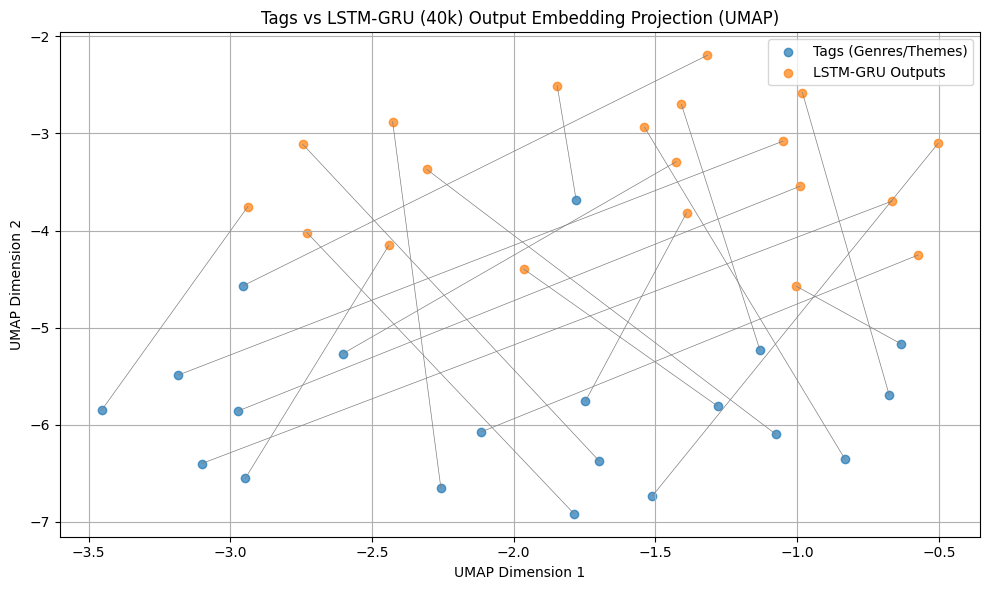

In [12]:
# --- UMAP Visualization ---
tags_to_match = test_df_results["tags_combined"].fillna("").tolist()
generated_outputs = test_df_results["generated"].tolist()

tags_embeddings = embedding_model.encode(tags_to_match)
output_embeddings = embedding_model.encode(generated_outputs)

all_embeddings = np.vstack([tags_embeddings, output_embeddings])
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(all_embeddings)

n = len(tags_to_match)
umap_tags = umap_embeddings[:n]
umap_outputs = umap_embeddings[n:]

plt.figure(figsize=(10, 6))
plt.scatter(umap_tags[:, 0], umap_tags[:, 1], label="Tags (Genres/Themes)", alpha=0.7)
plt.scatter(umap_outputs[:, 0], umap_outputs[:, 1], label="LSTM-GRU Outputs", alpha=0.7)

for i in range(n):
    plt.plot([umap_tags[i, 0], umap_outputs[i, 0]],
             [umap_tags[i, 1], umap_outputs[i, 1]],
             c='gray', linewidth=0.5)

plt.title("Tags vs LSTM-GRU (40k) Output Embedding Projection (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()